## **Исходные данные:**

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

**Условия соревнования:**
* Данное соревнование является бессрочным и доступно для всех потоков.

* Срок выполнения соревнования устанавливается индивидуально в каждом потоке.

* Тестовая выборка представлена в LeaderBoard целиком.

* Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.


**Метрика качества**<br>
Результаты оцениваются по метрике MAPE ## Файл представления Для каждого **id** отеля в наборе тестовых данных вы должны предсказать рейтинг отеля для **reviewer_score** переменной. Файл должен содержать заголовок и иметь следующий формат: 
       ```reviewer_score,id 1,1```

**Файлы для соревнования**
* hotels_train.csv - набор данных для обучения
* hotels_test.csv - набор данных для оценки качества
* submission.csv - файл сабмишна в нужном формате

## **Решение:**

In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [91]:
# Импорт необходимых библиотек
import matplotlib.pyplot as plt
import seaborn as sns 
import folium
import re
from collections import Counter
import plotly.express as px

from sklearn.model_selection import train_test_split  # для разделения данных на обучающую и тестовую выборку
from sklearn.ensemble import RandomForestRegressor # импортирует регрессор на основе случайного леса (Random Forest Regressor).
from sklearn import metrics # импортирует метрики для оценки качества модели

# Устанавливаем фиксированный RANDOM_SEED, чтобы результаты кода были одинаковыми при каждом запуске, 
# независимо от среды выполнения
RANDOM_SEED = 42

# Фиксируем версии библиотек, чтобы код выполнялся с теми же зависимостями, что и при первоначальном
# запуске
!pip freeze > requirements.txt

## **1. Загрузка данных**

Импортируем данные и выполняем базовую обработку данных

In [92]:
# Загружаем данные
df_train = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv') # набор данных для обучения
df_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv') # набор данных для оценки качества
sample_submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv') # файл сабмишна 

In [93]:
#  Выводим основную информацию о числе непустых значений в столбцах и их типах в датафрейме df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [94]:
# Выводим основную информацию о числе непустых значений в столбцах и их типах в датафрейме df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [95]:
# Выводим основную информацию о числе непустых значений в столбцах и их типах
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [96]:
# Временно объединяем обучающую и тестовую выборку данных для дальнейшей обработки. 
# Каждый датасет помечаем признаком sample, чтобы позже разделить их перед этапом моделирования.
df_train['sample'] = 1 # помечаем, где у нас обучающая выборка
df_test['sample'] = 0 # помечаем, где у нас тестовая выборка
df_test['reviewer_score'] = 0 # т.к. в тестовой выборке у нас нет значения reviewer_score,то мы его должны предсказать, временно заполняем нулями
df_hotels = pd.concat([df_test, df_train], ignore_index=True) # объединяем данные

In [97]:
# Выводим первые 5 строк датайрейма df_hotels
df_hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


**Признаки**

* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days продолжительность (в днях) между датой отзыва и датой обработки/очистки данных.и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля

In [98]:
# Размерность датафрейма df_hotels
df_hotels.shape

(515738, 18)

In [99]:
# Выводим основную информацию о числе непустых значений в столбцах и их типах в датафрейме df_hotels
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [100]:
# Определим числовые и категориальные признаки в датафрейме df_hotels
numeric_columns = df_hotels.select_dtypes(include=['int64', 'float64'])
categorical_columns = df_hotels.select_dtypes(include=['object'])

print("Числовые признаки:")
for col in numeric_columns:
    print(col)

print("\nКатегориальные признаки:")
for col in categorical_columns:
    print(col)

Числовые признаки:
additional_number_of_scoring
average_score
review_total_negative_word_counts
total_number_of_reviews
review_total_positive_word_counts
total_number_of_reviews_reviewer_has_given
lat
lng
sample
reviewer_score

Категориальные признаки:
hotel_address
review_date
hotel_name
reviewer_nationality
negative_review
positive_review
tags
days_since_review


**Вывод:**<br>
Объединенные данные представляют таблицу, состояющую из 515 738 строк и 18 столбцов. Типы данных: float64(4), int64(6), object(8)<br>
Числовые признаки датафрема df_hotels: 
additional_number_of_scorin, 
average_sco, e
review_total_negative_word_cou, ts
total_number_of_rev, ews
review_total_positive_word_c, unts
total_number_of_reviews_reviewer_has, giv, n
, at
ln, 
sample
revi.<br>
Категориальные признаки: 
hotel_addres, 
review_da, e
hotel_n, me
reviewer_nationa, ity
negative_r, view
positive_, evie, 
tags
days_sinc.e_reviewewer_score.

## **2. Очистка данных**

Выполняем подготовку данных для анализа

In [101]:
# Выполним проверку на наличие пропущенных значений NaN в датафрейме df_hotels можно выполнив:
df_hotels.isna().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

In [102]:
# Для столбцов (lat - широта, lng-долгота) заменим отсутствующие значения на 0:
df_hotels['lat'] = df_hotels['lat'].fillna(0)
df_hotels['lng'] = df_hotels['lng'].fillna(0)

In [103]:
# Выполним проверку на наличие дубликатов
duplicates = df_hotels[df_hotels.duplicated()]
print(f"Количество дубликатов: {len(duplicates)}")

Количество дубликатов: 336


In [104]:
# Удалим дубликаты
df_hotels = df_hotels.drop_duplicates()
print(f"Количество строк после удаления дубликатов: {len(df_hotels)}")

Количество строк после удаления дубликатов: 515402


In [105]:
# Приведем признак даты 'review_date' к формату datetime
df_hotels['review_date'] = pd.to_datetime(df_hotels['review_date']).dt.date

In [106]:
# Приведем признак 'days_since_review' к числовому типу данных, удалив слова day(s) в датафрейме
df_hotels['days_since_review'] = df_hotels['days_since_review'].apply(
    lambda x: int(re.findall(r'\d+', x)[0])).astype('int16')

In [107]:
# Удалим лишние пробелы в признаках 'reviewer_nationality', 'negative_review', 'positive_review'
df_hotels['reviewer_nationality'] = df_hotels['reviewer_nationality'].apply(lambda x: x.strip())
df_hotels['negative_review'] = df_hotels['negative_review'].apply(lambda x: x.strip())
df_hotels['positive_review'] = df_hotels['positive_review'].apply(lambda x: x.strip())

In [108]:
# Преобразуем значение рейтинга в целые числа
df_hotels.reviewer_score = df_hotels.reviewer_score.astype(int)

**Вывод:**<br>
Таким образом, на данном этапе выполнили подготовку данных для дальнейшего анализа

## **3. Исследование данных (EDA). <br>  Генерация признаков. <br>  Преобразование признаков**

Проведем анализ данных для обнаружения закономерностей, тенденций и их взаимосвязей

In [109]:
# Сводная статистика по датафрейму df_hotels
df_hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,reviewer_score
count,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000
mean,498.288753,8.397653,18.539901,2744.281231,17.777527,7.165120,354.404213,49.129315,2.806184,0.749892,6.010312
std,500.624467,0.548032,29.691326,2317.869392,21.803563,11.038862,208.913902,5.229615,4.571809,0.433075,3.789140
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.212857,-0.143372,0.000000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.000000,1.000000,7.000000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,527.000000,51.516288,4.831098,1.000000,9.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,10.000000


array([[<Axes: title={'center': 'additional_number_of_scoring'}>,
        <Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>,
        <Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<Axes: title={'center': 'days_since_review'}>,
        <Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lng'}>],
       [<Axes: title={'center': 'sample'}>,
        <Axes: title={'center': 'reviewer_score'}>, <Axes: >]],
      dtype=object)

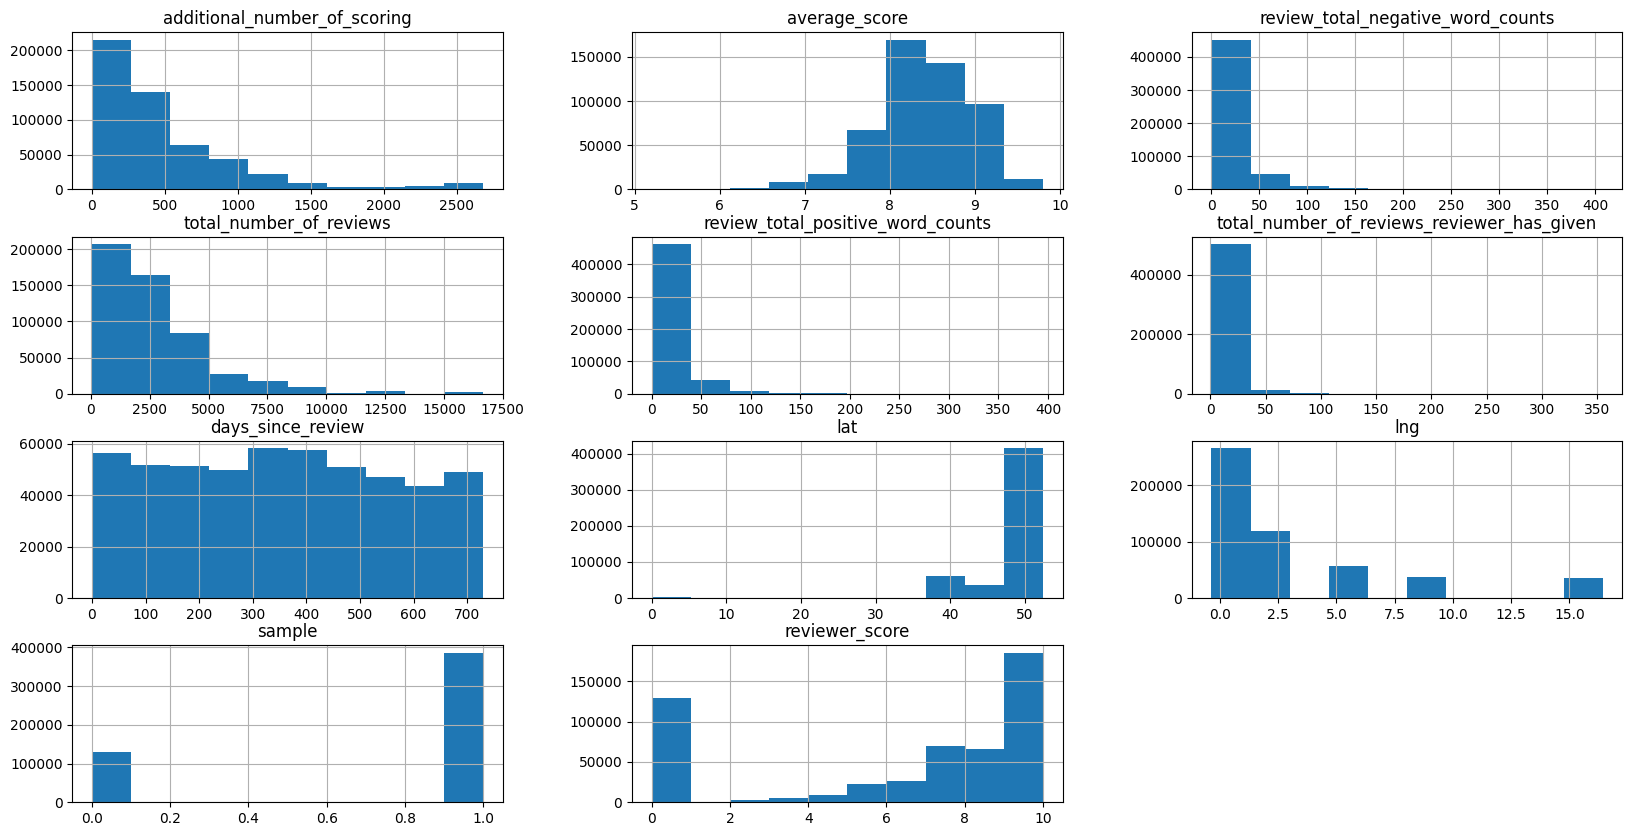

In [110]:
# Построим гистограммы для всех числовых столбцов в датафрейме df_hotels
df_hotels.hist(figsize=(20,10))

**Выводы по сводной статистики для числовых признаков:**<br>
* 'additional_number_of_scoring' - высокий уровень оценок без отзывов об отеле может говорить о том, что отель является более популярным и посещаемым, так что многие гости предпочитают оставить только оценку, не углубляясь в написание подробного отзыва,а низкий уровень оценок соответственно говорит об обратном;
* 'average_score'- cредний балл для большинства отелей находится в диапазоне от 8.1 до 8.8, что говорит о высоких оценках;
* 'review_total_negative_word_counts'- число слов в отрицательных отзывах распределено в диапазоне от 2 до 23 слов, что говорит о том, что пользователи предпочитают оставлять как краткие отзывы с несколькими ключевыми словами для описания проблемы, так длинные отзывы с более подробным описанием негативных впечатлений об отели. Также стоить отметить, что отрицательные отзывы содержат меньше слов, чем положительные, что видно по меньшему среднему значению; 
* 'total_number_of_reviews' - общее количество действительных отзывов об отеле распределено в диапазоне 1161 до 3633 отзыва, что говорит о том, что отели с большим числом отзывов являются наиболее популярными, с низким количеством отзывов соответственно наоборот или это также может говорить о недостаточно долгом присутствии отеля на рынке;
* 'review_total_positive_word_counts'- число слов в положительных отзывах распределено в диапазоне от 5 до 22 слов случаев, что говорит о том, что пользователи предпочитают оставлять как краткие отзывы с несколькими ключевыми словами о положительном опыте посещения отеля, так и длинные отзывы с подробным описанием;
* 'total_number_of_reviews_reviewer_has_given' - количество отзывов, которые рецензенты дали в прошлом, показывает активность рецензентов. Диапазон значений от 1 до 8 отзывов.
* 'days_since_review'- продолжительность (в днях) между датой отзыва и датой обработки/очистки данных, показывает давность отзыва, т.е. его акутальность;
* 'reviewer_score' - большинство отзывов находятся в верхней части шкалы, что может указывать на общий высокий уровень удовлетворенности гостей.

Последовательно рассмотрим все признаки датафрема df_hotels, оценим их содержание и сформулируем гипотезы

* **hotel_address - адрес отеля**

In [111]:
df_hotels['hotel_address'].head()

0                   Via Senigallia 6 20161 Milan Italy
1    Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2          Mallorca 251 Eixample 08008 Barcelona Spain
3    Piazza Della Repubblica 17 Central Station 201...
4    Singel 303 309 Amsterdam City Center 1012 WJ A...
Name: hotel_address, dtype: object

In [112]:
# Выделим страну и город из признака hotel_address: city и country, в котором расположен отель
# Также в код добавим поправку на неверное отображение страны 'Kingdom', вместо полного названия страны 'United Kingdom'
# И добавим аналогично поправку на неверное отображение города 'Kingdom', вместо 'London'
df_hotels['country'] = df_hotels['hotel_address'].apply(lambda x: x.split(' ')[-1] if x.split(' ')[-1]!='Kingdom' else 'United Kingdom') 
df_hotels['city'] = df_hotels['hotel_address'].apply(lambda x: x.split(' ')[-2] if x.split(' ')[-1]!='Kingdom' else 'London')

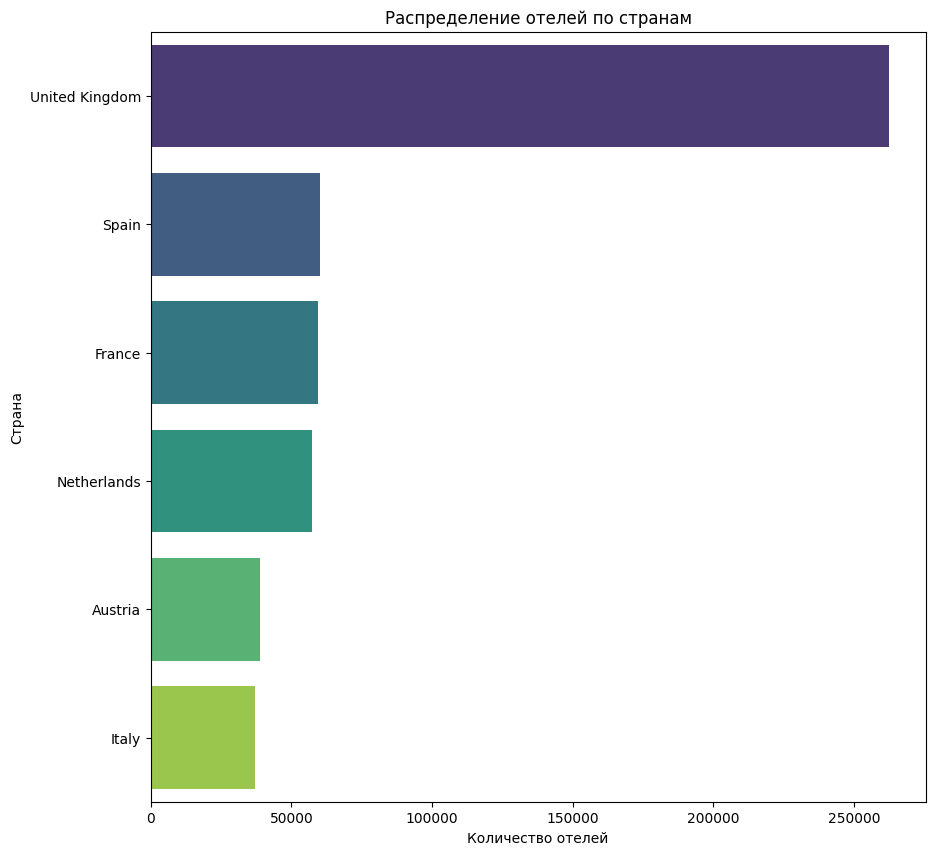

In [113]:
# Постром график распределения отелей по странам
sorted_countries = df_hotels['country'].value_counts(ascending=False).index
sns.countplot(y=df_hotels['country'], palette='viridis', order=sorted_countries)
plt.title('Распределение отелей по странам')
plt.xlabel('Количество отелей')
plt.ylabel('Страна')
plt.show()

In [114]:
display(df_hotels.groupby(['country', 'city'])['hotel_address'].count())

country         city     
Austria         Vienna        38938
France          Paris         59598
Italy           Milan         37206
Netherlands     Amsterdam     57212
Spain           Barcelona     60149
United Kingdom  London       262299
Name: hotel_address, dtype: int64

In [115]:
# Выведим уникальные названия городов
df_hotels['city'].unique()

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

In [116]:
# Преобразуем категориальный столбец 'city' в бинарные столбцы
df_hotels = df_hotels.fillna(0)  # заполним пропуски в датафрейме нулями 
df_hotels = pd.get_dummies(df_hotels, columns=['city'], dtype='uint8')  # Преобразование с типом uint8

In [117]:
# Удаляем столбцы 'country' и 'hotel_address'
df_hotels = df_hotels.drop(['country', 'hotel_address'], axis=1)
# Выводим размерность данных после преобразования
df_hotels.shape

(515402, 23)

**Вывод:** 
1. В представленном датафрейме фигурируют 6 стран, в которых расположенны отели;
2. Наибольшее количество отелей распределенно в Великобритании, наименьшее количество отелей в Италии;
3. Разделение признака 'hotel_address' на город и страну,а также удаление признака страны позволит наиболее эффективно использовать полученные данные в дальнейшем анализе и обучении модели

* **review_date - дата, когда рецензент разместил соответствующий отзыв**

Данный признак позволяет выявить сезонность отзывов

In [118]:
# Выделим месяц и квартал (сезонность посещения отеля) из признака review_date: review_month и review_quarter.
# Квартал:
# 1: январь–март
# 2: апрель–июнь
# 3: июль–сентябрь
# 4: октябрь–декабрь
df_hotels['review_month'] = pd.to_datetime(df_hotels['review_date']).dt.month
df_hotels['review_quarter'] = pd.to_datetime(df_hotels['review_date']).dt.quarter

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


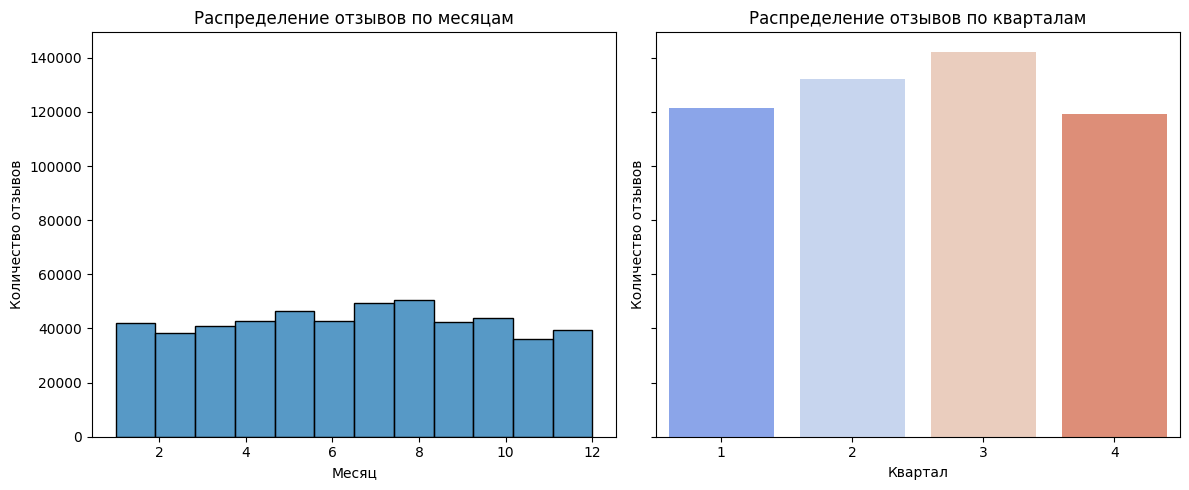

In [119]:
# Настройка холста
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True) 

# Построим график распределения отзывов по месяцам
sns.histplot(df_hotels['review_month'], bins=12, kde=False, ax=axes[0])
axes[0].set_title('Распределение отзывов по месяцам')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Количество отзывов')

# Построим график распределения отзывов по кварталам
sns.countplot(x='review_quarter', data=df_hotels, palette='coolwarm', ax=axes[1])
axes[1].set_title('Распределение отзывов по кварталам')
axes[1].set_xlabel('Квартал')
axes[1].set_ylabel('Количество отзывов')

plt.tight_layout() 
plt.show()

In [120]:
# Удалим признак 'review_date'
df_hotels.drop('review_date', axis = 1, inplace=True)
df_hotels.shape

(515402, 24)

**Вывод:** Графики распределения отзывов по месяцам и по кварталам показывают о наличие сезонных факторов, которые влияют на количество отзывов об отеле. Пик отзывов приходится на летний период, небольшой спад  наблюдается в ноябре. Однако в целом можно отметить, что значительных колебаний в количестве отзывов по сезонам не наблюдается.

* **hotel_name - название отеля**

In [121]:
# Выведим статистическую информацию для признака hotel_name
df_hotels['hotel_name'].describe()

count                                         515402
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: hotel_name, dtype: object

Как видно данный признак содержит 1492 уникальных названий отелей, то есть данные сгруппированы в разрезе названия отеля. Поэтому закодируем название отеля для дальнейшего моделирования,где числовые значения предпочтительнее, чем строки, а признак 'hotel_name' удалим.

In [122]:
# Преобразуем столбец hotel_name в категориальный тип данных - category
df_hotels['hotel_name'] = df_hotels['hotel_name'].astype('category') 
# Преобразуем каждый уникальный отель в числовой код (индекс), который сохраняется в новом столбце hotel_name_code
df_hotels['hotel_name_code'] = df_hotels['hotel_name'].cat.codes
# Выведим таблицу содержащую два столбца hotel_name  и hotel_name_code 
df_hotels[['hotel_name', 'hotel_name_code']]

,hotel_name,hotel_name_code
0,Hotel Da Vinci,612
1,Urban Lodge Hotel,1445
2,Alexandra Barcelona A DoubleTree by Hilton,33
3,Hotel Principe Di Savoia,735
4,Hotel Esther a,633
...,...,...
515733,Hotel Moonlight,711
515734,BEST WESTERN PLUS Amedia Wien,104
515735,Bloomsbury Palace Hotel,177
515736,The Marble Arch London,1364


In [123]:
# Удалим признак 'hotel_name'
df_hotels.drop('hotel_name', axis = 1, inplace=True)

* **reviewer_nationality - национальность рецензента**

In [124]:
# Выведим статистическую информацию для признака reviewer_nationality
df_hotels['reviewer_nationality'].describe()

count             515402
unique               227
top       United Kingdom
freq              245158
Name: reviewer_nationality, dtype: object

Как видно данный признак содержит 227 уникальных национальностей, для удобства визуализации данного признака выделим топ-15 национальностей рецензентов, выполнив сдедующий код:

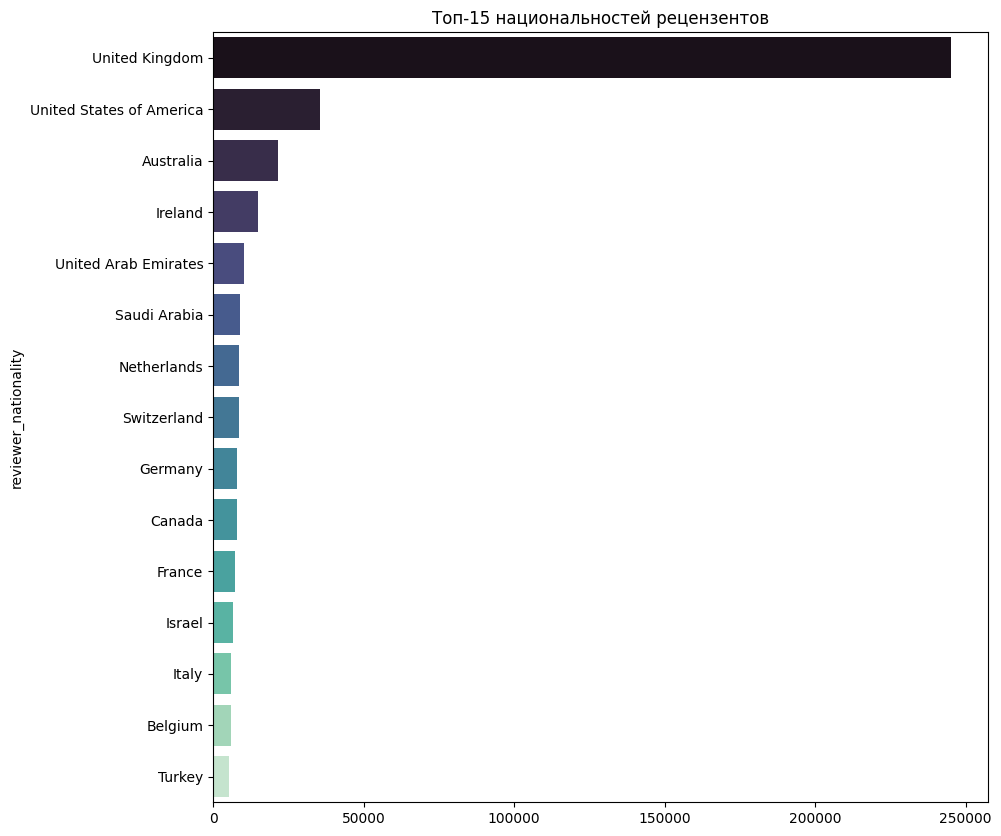

In [125]:
# Строим график топ-15 национальностей рецензентов
top_nationalities = df_hotels['reviewer_nationality'].value_counts().head(15) # подсчет количества уникальных значений (топ-15 национальностей)
sns.barplot(y=top_nationalities.index, x=top_nationalities.values, palette='mako')
plt.title('Топ-15 национальностей рецензентов')
plt.show()

Для дальнейшего анализа и обучения модели извлечем самые популярные национальности рецензентов и выделим их в отдельные признаки, при этом национальности рецензентов,
которые оставили менее 7000 отзвывов объединим в новый признак 'reviewer_nationality_other'

In [126]:
# Выполняем подсчёт количества отзывов по каждой национальности
df_nationality = pd.DataFrame(df_hotels['reviewer_nationality'].value_counts()).reset_index()
df_nationality.columns = ['nationality', 'count']

# Выполним отбор самых популярных национальностей рецензентов,оставляем только национальности с количеством записей больше или равным 7000
df_nationality = df_nationality[df_nationality['count'] >= 7000]

# Создаем бинарные признаки для каждой национальности
for nat in df_nationality['nationality']:
    df_hotels['reviewer_nationality_' + str(nat)] = df_hotels['reviewer_nationality'].apply(lambda x: 1 if x == nat else 0)

# Создаем признак 'reviewer_nationality_other'
df_hotels['reviewer_nationality_other'] = df_hotels['reviewer_nationality'].apply(lambda x: 1 if x not in df_nationality['nationality'].values else 0)

# Удалим признак 'reviewer_nationality'
df_hotels.drop('reviewer_nationality', axis=1, inplace=True)

**Вывод:** График топ-15 национальностей рецензентов для признака 'reviewer_nationality' показывает, что возглавляет данный топ рецензенты из Великобритании, что скорее связанно, что  наибольшее количество отелей распределенно в Великобритании, что было выявленно ранее.

* **negative_review - отрицательный отзыв, который рецензент дал отелю**

In [127]:
# Выведим статистическую информацию для признака 'negative_review'
df_hotels['negative_review'].describe()

count          515402
unique         326566
top       No Negative
freq           127807
Name: negative_review, dtype: object

In [128]:
# Выведим топ-10 наиболее часто встречающихся негативных отзывов
df_hotels['negative_review'].value_counts().head(10)

negative_review
No Negative       127807
Nothing            18525
nothing             2506
None                1166
N A                 1060
                     849
Nothing really       569
N a                  520
All good             469
Small room           455
Name: count, dtype: int64

In [129]:
# Создадим функцию для определения наличия негатива в отзыве
def has_negative(review):
    if not review.strip() or review.lower() in ['no negative', 'none']: 
        return 0  
    return 1 
# Примененим функцию к столбцу с негативными отзывами
df_hotels['has_negative'] = df_hotels['negative_review'].apply(has_negative)
print(df_hotels[['negative_review', 'has_negative']].head())

                                     negative_review  has_negative
0  Would have appreciated a shop in the hotel tha...             1
1        No tissue paper box was present at the room             1
2                                            Pillows             1
3                                        No Negative             0
4                                        No Negative             0


In [130]:
df_hotels.drop(['negative_review'], axis = 1, inplace=True)

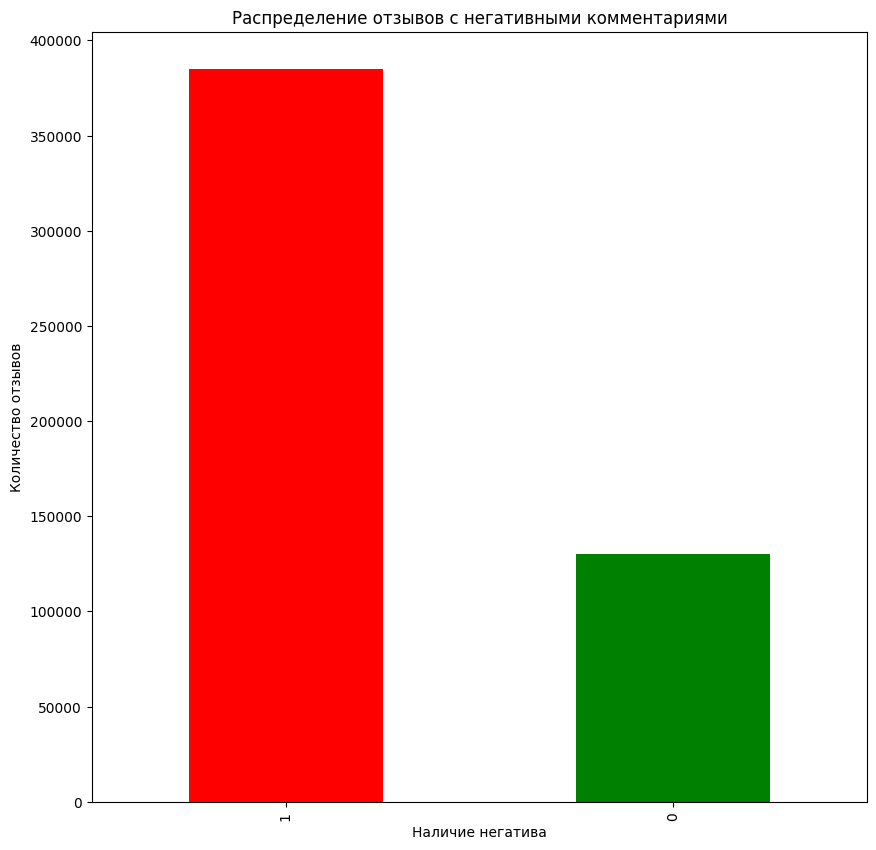

In [131]:
# Построим график распределения отзывов с негативными комментариями
df_hotels['has_negative'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Распределение отзывов с негативными комментариями')
plt.xlabel('Наличие негатива')
plt.ylabel('Количество отзывов')
plt.show()

In [132]:
df_hotels['has_negative'].value_counts()

has_negative
1    385245
0    130157
Name: count, dtype: int64

**Вывод:** График распределения отзывов с негативными комментариями показывает, что в большинстве своем рецензенты предпочитают оставить комментарий, если их что-то не устроило в сервисе. Преобразования признака 'negative_review' обеспечивают дополнительную ценность для последующего анализа данных и построения модели машинного обучения.

* **positive_review - положительный отзыв, который рецензент дал отелю**

In [133]:
# Выведим статистическую информацию для признака 'positive_review'
df_hotels['positive_review'].describe()

count          515402
unique         407552
top       No Positive
freq            35923
Name: positive_review, dtype: object

In [134]:
# Выведим топ-10 наиболее часто встречающихся позитивных отзывов
df_hotels['positive_review'].value_counts().head(10)

positive_review
No Positive       35923
Location          10126
Everything         2897
location           1733
Nothing            1466
Great location     1417
The location       1338
Good location      1202
Breakfast           664
Friendly staff      602
Name: count, dtype: int64

In [135]:
# Создадим функцию для определения наличия позитиива в отзыве
def has_positive(review):
    if not review.strip() or review.lower() in ['no positive', 'none']: 
        return 0  
    return 1 
# Примененим функцию к столбцу с негативными отзывами
df_hotels['has_positive'] = df_hotels['positive_review'].apply(has_negative)
print(df_hotels[['positive_review', 'has_positive']].head())

                                     positive_review  has_positive
0  Hotel was great clean friendly staff free brea...             1
1                                        No Positive             1
2                         Nice welcoming and service             1
3  Everything including the nice upgrade The Hote...             1
4                     Lovely hotel v welcoming staff             1


In [136]:
df_hotels.drop(['positive_review'], axis = 1, inplace=True)

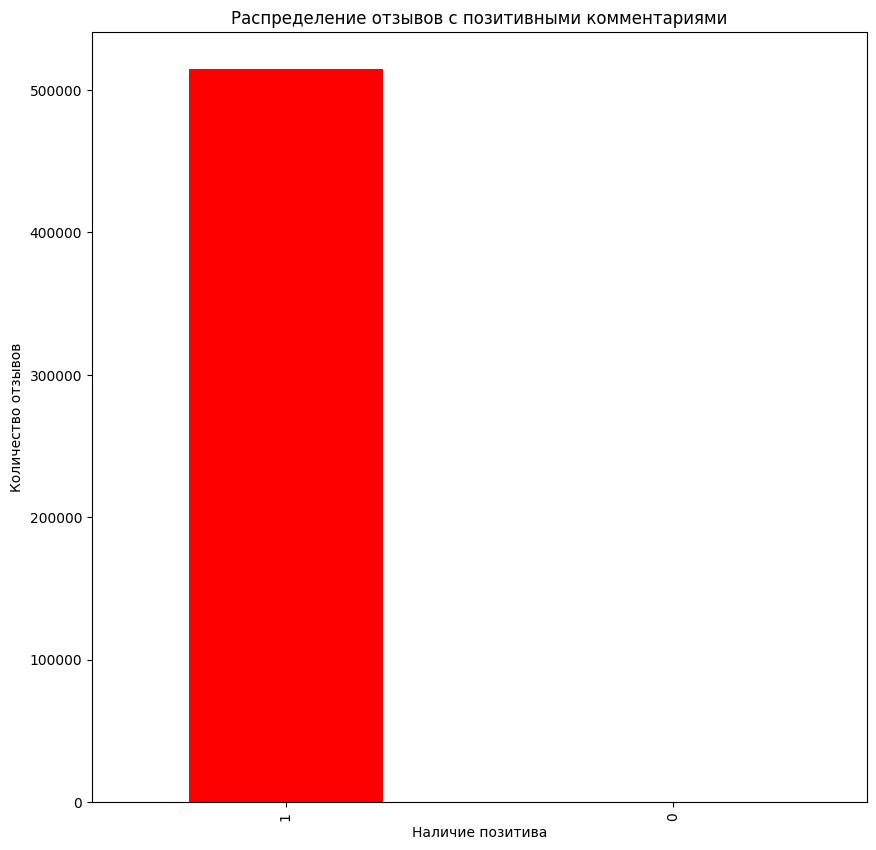

In [137]:
# Построим график распределения отзывов с позитивными комментариями
df_hotels['has_positive'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Распределение отзывов с позитивными комментариями')
plt.xlabel('Наличие позитива')
plt.ylabel('Количество отзывов')
plt.show()

In [138]:
df_hotels['has_positive'].value_counts()

has_positive
1    515180
0       222
Name: count, dtype: int64

**Вывод:** График распределения отзывов с позитивными комментариями показывает, что большинство рецензентов предпочитают оставлять комментарии, если они остались довольны предоставленным сервисом. Преобразования признака 'positive_review' обеспечивают дополнительную ценность для последующего анализа данных и построения моделей машинного обучения, улучшая их способность выявлять закономерности и предсказывать поведение клиентов.

* **tags - теги, которые рецензент дал отелю**

In [139]:
# Выведим статистическую информацию для признака 'tags'
df_hotels['tags'].describe()

count                                                515402
unique                                                55242
top       [' Leisure trip ', ' Couple ', ' Double Room '...
freq                                                   5101
Name: tags, dtype: object

Как видно данный признак содержит 55 242 уникальных тегов, для удобства визуализации данного признака выделим топ-15 наиболее популярных тегов, выполнив сдедующий код:

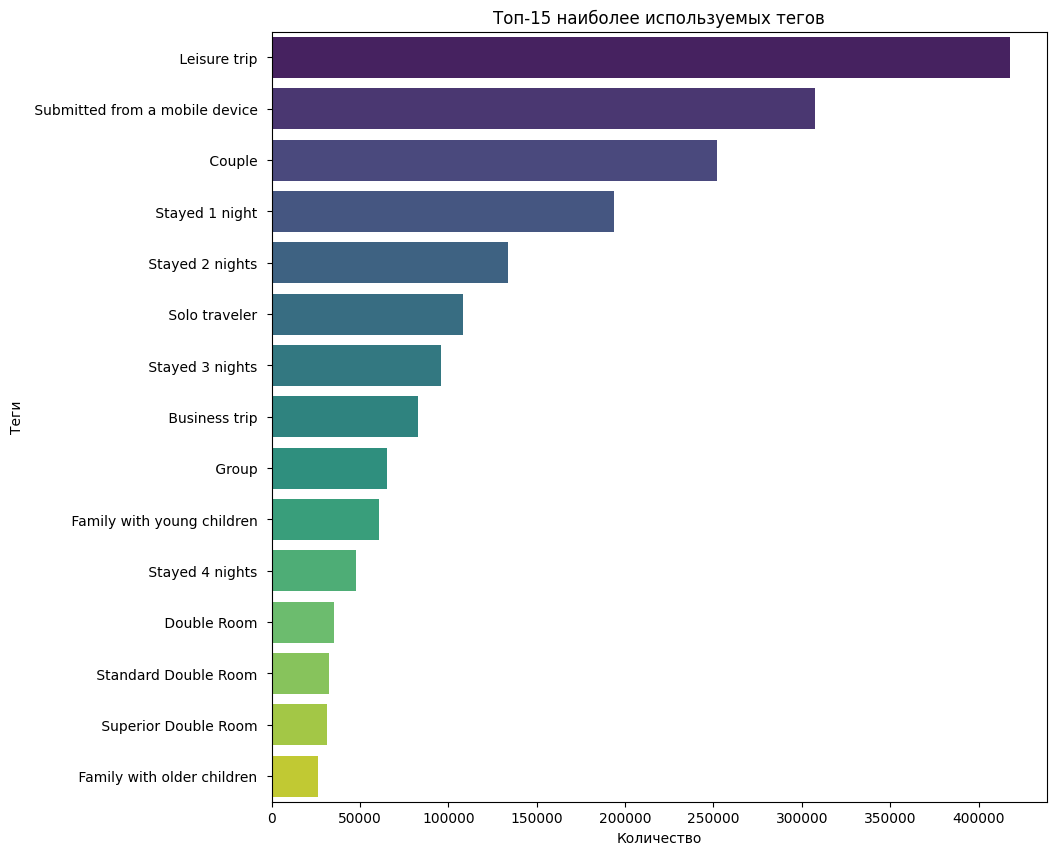

In [140]:
# Подсчет частоты использования тегов из столбца tags в датафрейме df_hotels
tags_counts = Counter([tag for tags in df_hotels['tags'] for tag in eval(tags)])

# Формируем датафрейм из топ-15 самых популярных тегов
df_tags = pd.DataFrame(tags_counts.most_common(15), columns=['Tags', 'Count']) 

# Строим график топ-15 наиболее используемых тегов
sns.barplot(y=df_tags['Tags'], x= df_tags['Count'], palette='viridis')
plt.title('Топ-15 наиболее используемых тегов')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

In [141]:
df_tags.head(15)

,Tags,Count
0,Leisure trip,417513
1,Submitted from a mobile device,307458
2,Couple,252117
3,Stayed 1 night,193557
4,Stayed 2 nights,133846
5,Solo traveler,108468
6,Stayed 3 nights,95754
7,Business trip,82880
8,Group,65357
9,Family with young children,60986


Для дальнейшего анализа и обучения модели преобразуем теги в список и создадим новые признаки для 15 самых частых тегов, отображенных на графике выше

In [142]:
t = ['[', ']', '"', "'"] # список, содержащий символы, которые в дальнейшем будут удалены

# Создадим функцию, которая преобразует текстовые строки из колонки tags в список
def tags_list(arg):
    for symbol in arg: 
        if symbol in t:
            arg = arg.replace(symbol, '')     
    arg = arg.split(', ')
    return arg 

In [143]:
# Топ-15 тегов для создания новых бинарных колонок
top_tags = [' Leisure trip ',
 ' Submitted from a mobile device ',
 ' Couple ',
 ' Stayed 1 night ',
 ' Stayed 2 nights ',
 ' Solo traveler ',
 ' Stayed 3 nights ',
 ' Business trip ',
 ' Group ',
 ' Family with young children ',
' Stayed 4 nights ',
 ' Double Room ',
 ' Standard Double Room ',
 ' Superior Double Room ',
 ' Family with older children ']

for tag in top_tags:
    tag_name = str(tag)
    df_hotels[tag_name] =  df_hotels['tags'].apply(lambda x: 1 if tag_name in x else 0)

In [144]:
# Удалим колонку tags,так как информация о тегах теперь представлена в новых бинарных колонках
df_hotels.drop('tags', axis = 1, inplace=True)

**Вывод:** График топ-15 наиболее используемых тегов для признака 'tags' показывает, что наиболее популярным тегом явдяется тег 'Leisure trip' или 'Туристическая поездка', количество упоминаний 417 513 раз из общего количества отзывов 515 402.

## **4. Отбор признаков**

In [145]:
# Выведим статистическую информацию для датафрейма df_hotels в результате выполненных преобразований
df_hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,Solo traveler,Stayed 3 nights,Business trip,Group,Family with young children,Stayed 4 nights,Double Room,Standard Double Room,Superior Double Room,Family with older children
count,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,...,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000
mean,498.288753,8.397653,18.539901,2744.281231,17.777527,7.165120,354.404213,49.129315,2.806184,0.749892,...,0.210453,0.185785,0.160807,0.126808,0.118327,0.092693,0.387183,0.070615,0.069059,0.051088
std,500.624467,0.548032,29.691326,2317.869392,21.803563,11.038862,208.913902,5.229615,4.571809,0.433075,...,0.407631,0.388934,0.367353,0.332758,0.322995,0.290002,0.487107,0.256181,0.253554,0.220178
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,-0.369758,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.212857,-0.143372,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,527.000000,51.516288,4.831098,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [146]:
#  Выведим основную информацию для датафрейма df_hotels в результате выполненных преобразований
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515402 entries, 0 to 515737
Data columns (total 49 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   additional_number_of_scoring                   515402 non-null  int64  
 1   average_score                                  515402 non-null  float64
 2   review_total_negative_word_counts              515402 non-null  int64  
 3   total_number_of_reviews                        515402 non-null  int64  
 4   review_total_positive_word_counts              515402 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given     515402 non-null  int64  
 6   days_since_review                              515402 non-null  int16  
 7   lat                                            515402 non-null  float64
 8   lng                                            515402 non-null  float64
 9   sample                                    

Построим тепловую карту, которая позволит визуально выявить мультиколлинеарные признаки, которые сильно коррелируют друг с другом. И на основании этой информации примем решение об удалении избыточных признаков

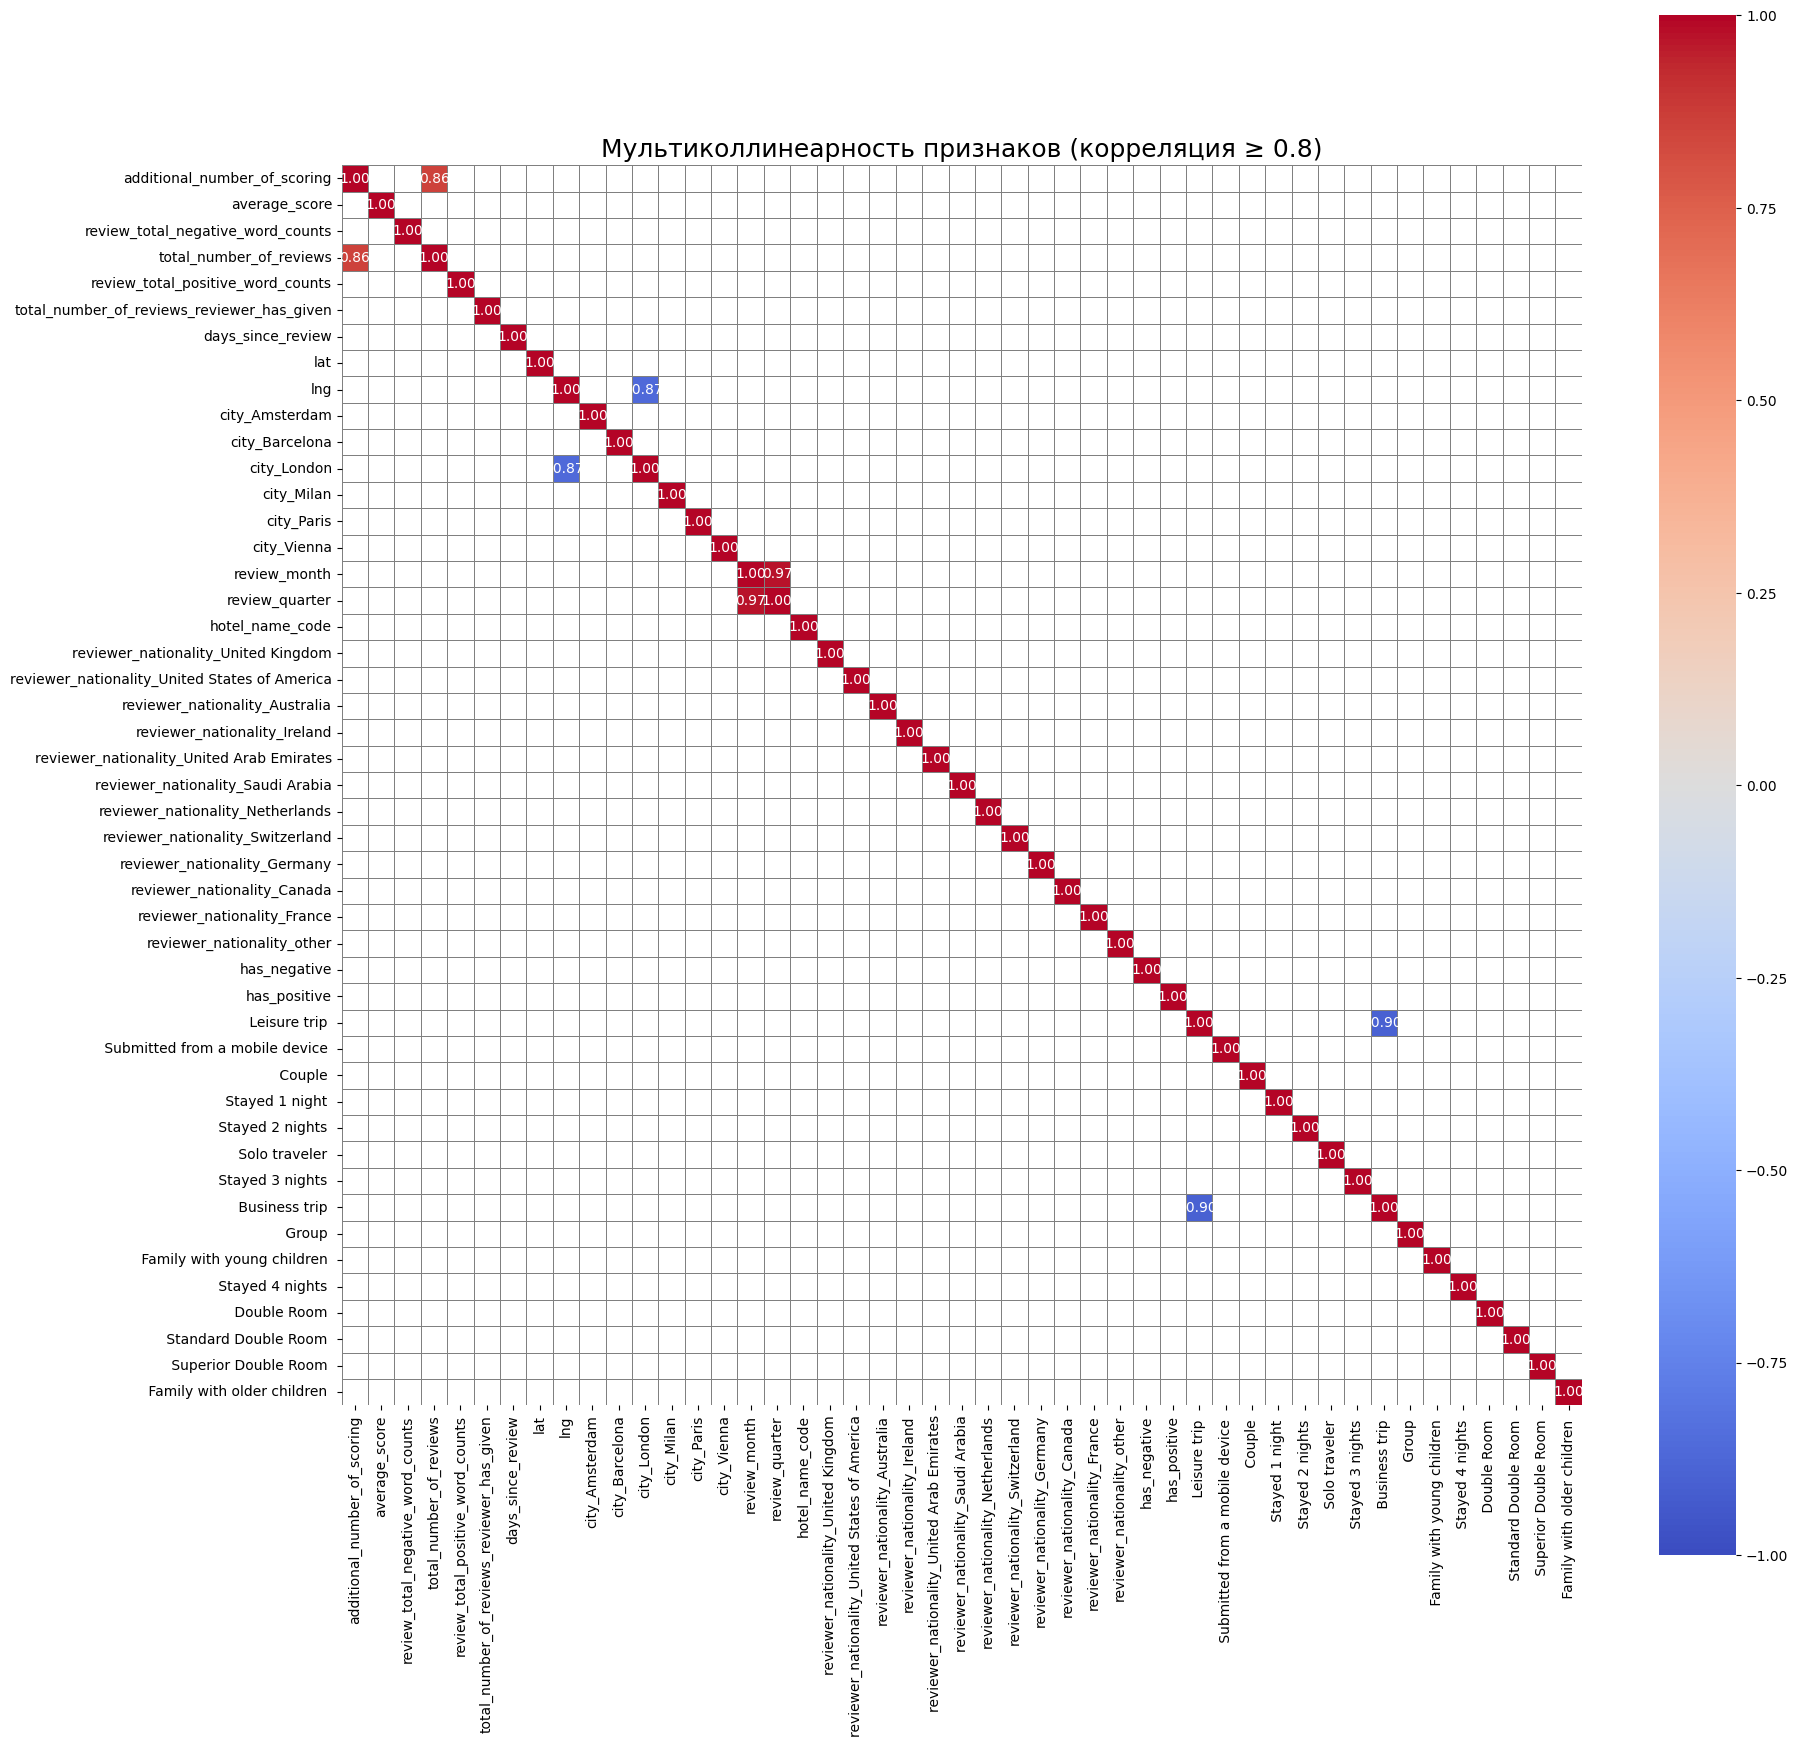

In [147]:
# Вычислим корреляционную матрицу с использованием метода Спирмана
corr = df_hotels.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')
# Фильтруем корреляции, оставляя только значения с абсолютной величиной выше 0.8
filtered_corr = corr.where(corr.abs() >= 0.8)

# Построим тепловую карту
plt.figure(figsize=(20, 20))
sns.heatmap(
    filtered_corr,            
    vmin=-1, vmax=1,          
    cmap='coolwarm',          
    annot=True,               
    fmt='.2f',                
    linewidths=0.5,            
    linecolor='gray',        
    square=True              
)

plt.title('Мультиколлинеарность признаков (корреляция ≥ 0.8)', fontsize=18)
plt.show()

In [148]:
# Удалим следующие избыточные признаки 
df_hotels = df_hotels.drop([' Business trip '], axis=1)

# Удаление других признаков приводило к ухудшению модели

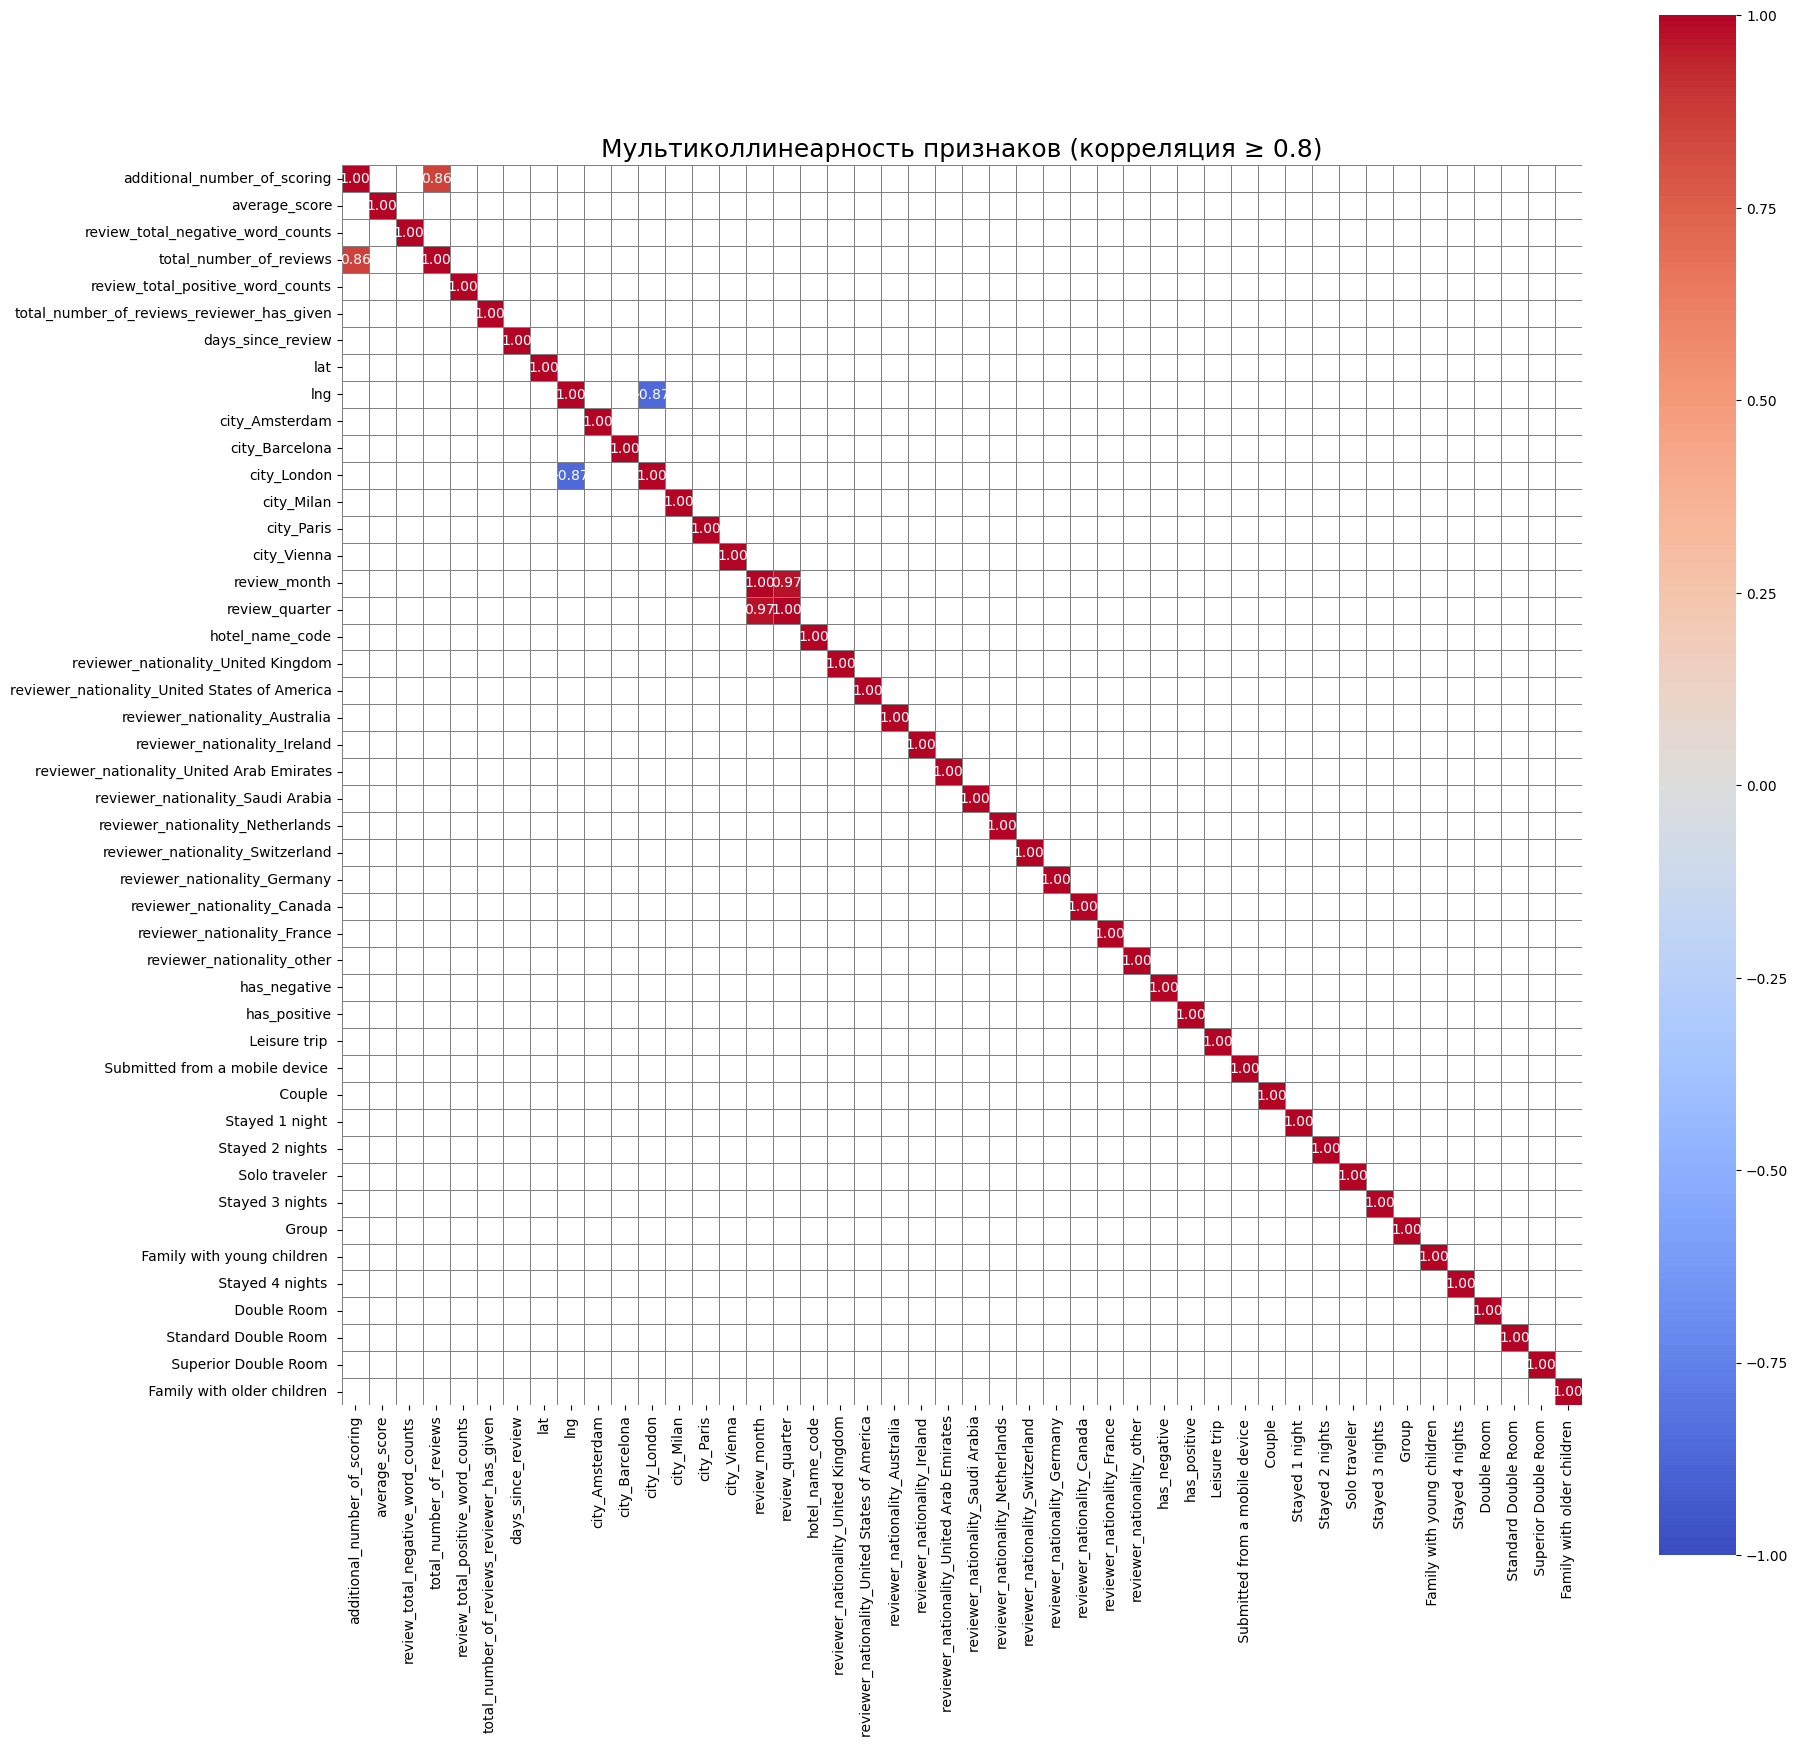

In [149]:
# Вычислим корреляционную матрицу с использованием метода Спирмана
corr = df_hotels.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')
# Фильтруем корреляции, оставляя только значения с абсолютной величиной выше 0.8
filtered_corr = corr.where(corr.abs() >= 0.8)

# Построим тепловую карту
plt.figure(figsize=(20, 20))
sns.heatmap(
    filtered_corr,            
    vmin=-1, vmax=1,          
    cmap='coolwarm',          
    annot=True,               
    fmt='.2f',                
    linewidths=0.5,            
    linecolor='gray',        
    square=True              
)

plt.title('Мультиколлинеарность признаков (корреляция ≥ 0.8)', fontsize=18)
plt.show()

**Вывод:** Таким образом, на данном этапе мы получили тепловую карту высококоррелированных признаков, где значения корреляции отображены визуально. И на основании этой информации приняли решение об удалении избыточных признаков

## **5. Обучение модели**

In [150]:
# Разделим обратно датасет на обучающий и тестовый набор данных
train_data = df_hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = df_hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values           
X = train_data.drop(['reviewer_score'], axis=1)

In [151]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных и выделим 20% данных на валидацию 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [152]:
# Проверим
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128906, 47), (386496, 47), (386496, 46), (309196, 46), (77300, 46))

In [153]:
# Создаём модель 
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [154]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовом наборе и предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


In [155]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика MAPE (Mean Absolute Percentage Error) - показатель, который измеряет, насколько предсказанные значения модели отклоняются от реальных значений 
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 1.03443847563605


<Axes: >

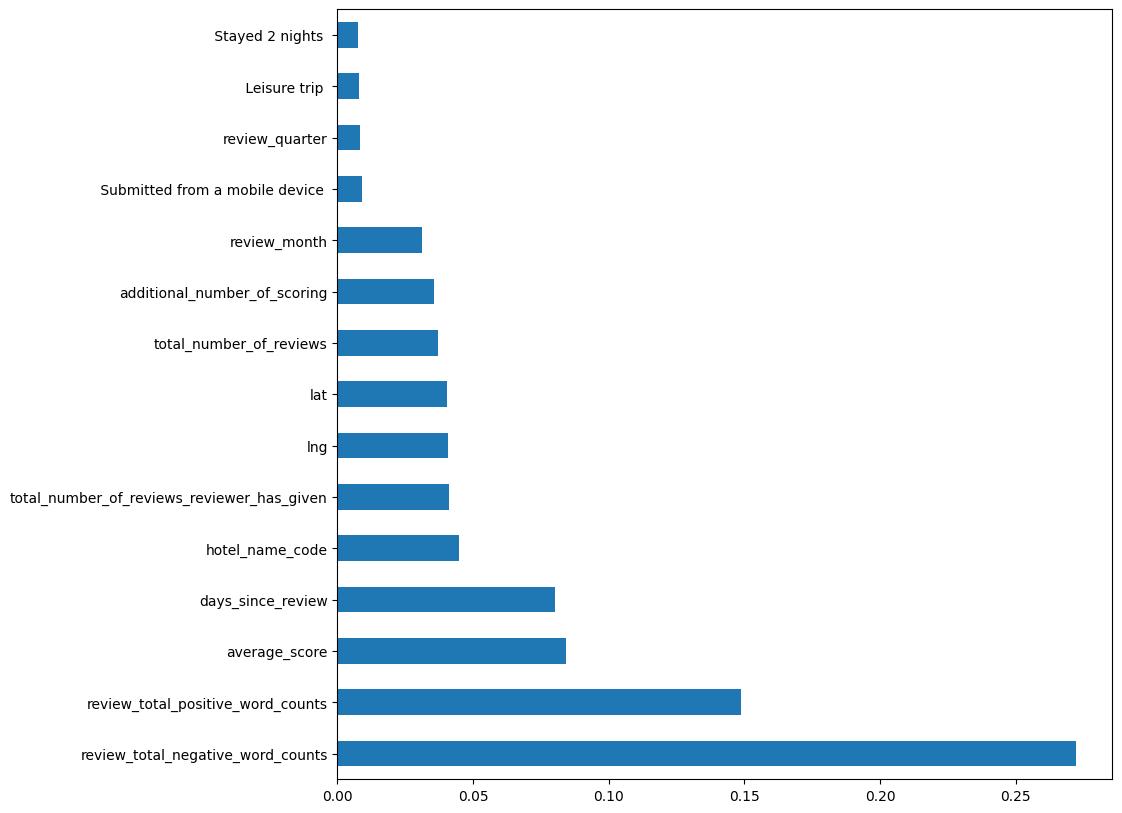

In [156]:
# Выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [157]:
# Выведим 10 случайных строк из тестового набора данных test_data
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,Stayed 2 nights,Solo traveler,Stayed 3 nights,Group,Family with young children,Stayed 4 nights,Double Room,Standard Double Room,Superior Double Room,Family with older children
80577,32,8.0,7,359,3,1,465,48.874067,2.350217,0,...,0,0,0,0,0,0,1,1,0,0
36314,914,8.5,7,7586,0,1,264,52.385601,4.847060,0,...,0,0,0,0,0,1,0,0,0,0
95339,28,8.0,46,268,22,3,653,48.850307,2.345061,0,...,0,0,1,0,0,0,0,0,0,0
42417,196,9.3,4,931,59,20,497,51.520181,-0.125696,0,...,1,0,0,0,0,0,1,0,0,0
119675,309,8.1,6,2270,2,5,576,52.351145,4.874076,0,...,0,0,1,0,0,0,0,0,0,0
102382,834,9.1,17,4687,40,10,483,52.370545,4.888644,0,...,1,0,0,0,0,0,0,0,0,0
26520,602,8.5,12,2494,2,1,563,51.506935,-0.126012,0,...,0,0,0,0,0,0,0,0,0,0
120444,197,9.4,44,644,51,1,212,51.520857,-0.077950,0,...,0,0,0,0,0,0,1,0,1,0
88983,115,9.1,49,953,48,1,342,41.394924,2.159310,0,...,0,0,0,0,0,0,1,1,0,0
61495,396,7.9,0,3944,2,4,242,41.398932,2.202418,0,...,0,1,1,0,0,0,0,0,0,0


In [158]:
# Удалим признак 'reviewer_score' из набора данных test_data
test_data = test_data.drop(['reviewer_score'], axis=1)

In [159]:
# Выведим данные sample_submission
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [160]:
# Обученная модель используется для предсказания результатов на данных test_data
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.6s finished


In [161]:
# Выведим данные predict_submission
predict_submission

array([8.6 , 6.74, 7.63, ..., 7.28, 9.22, 7.02])

In [162]:
list(sample_submission)

['reviewer_score', 'id']

In [167]:
# Преобразуем его в pandas Series
predict_submission = pd.Series(predict_submission)
# Присваиваем значения в столбец reviewer_score
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)
print(sample_submission.head(10))

   reviewer_score      id
0            8.60  488440
1            6.74  274649
2            7.63  374688
3            9.38  404352
4            9.35  451596
5            8.25  302161
6            7.90  317079
7            7.43   13963
8            8.12  159785
9            7.83  195089


**Итого:** В ходе разработки модели для предсказания рейтинга отеля были получены следующие результаты: MAPE (Mean Absolute Percentage Error) составляет 1.03%. Это указывает на то, что в среднем предсказания модели отклоняются от фактических значений на 1.03%, что является довольно хорошим показателем.